В качестве реального датасета использован открытый погодный датасет города Basel. Данные представлены с шагом 1 час и содержат:
- температуру воздуха (°C)
- относительную влажность (%)
- атмосферное давление (переведено в мм рт. ст.)
- временную метку

## KDE

<!-- Формула ядерной оценки плотности -->
**Оценка плотности (Kernel Density Estimation):**
$$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - X_i}{h} \right)
$$

<!-- Формула гауссового ядра -->
**Гауссово ядро:**
$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{u^2}{2} \right)
$$

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

class TestKernelDensity:
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        """ bandwidth — ширина окна (h); kernel — тип ядра (только 'gaussian') """
        self.bandwidth = bandwidth
        self.kernel = kernel
        if kernel != 'gaussian':
            raise NotImplementedError("Поддерживается только 'gaussian'")

    def fit(self, X):
        """ Сохраняем обучающие точки """
        self.X_ = np.array(X).reshape(-1, 1)
        return self

    def score_samples(self, X):
        """
        Вычисление log(плотности) по формуле:
        f(x) = 1/(n h) * sum K((x - X_i)/h)
        с ядром K(u) = 1/sqrt(2pi) * exp(-u^2 / 2)
        """
        if not hasattr(self, "X_"):
            raise ValueError("Сначала вызовите fit()")

        X = np.array(X).reshape(-1, 1)
        n = self.X_.shape[0]
        h = self.bandwidth

        # (x - X_i) / h
        u = (X - self.X_.T) / h  # shape: [len(X), n]

        # K(u)
        K_u = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

        # f(x)
        f_x = K_u.sum(axis=1) / (n * h)

        return np.log(f_x)

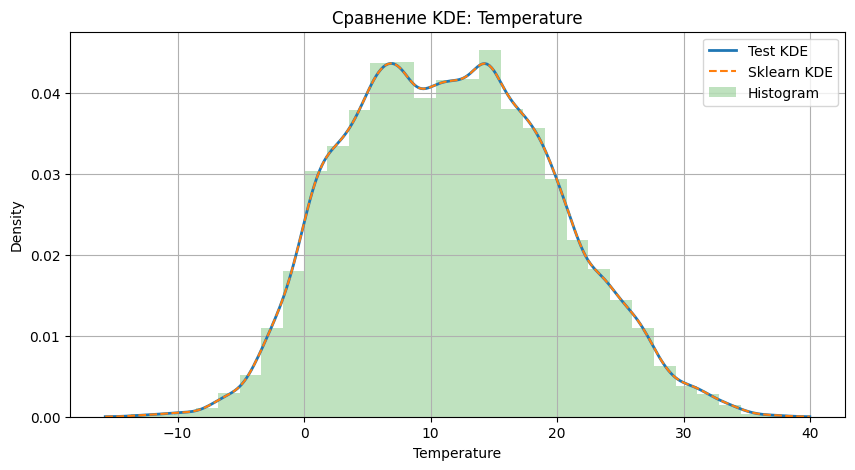

In [14]:
weather_df = pd.read_csv("weather.csv")
X = weather_df["Temperature"].values.reshape(-1, 1)

bandwidth = 1.0
x_vals = np.linspace(X.min() - 2, X.max() + 2, 300).reshape(-1, 1)

custom_kde = TestKernelDensity(bandwidth=bandwidth).fit(X).score_samples(x_vals)
log_dens_custom = custom_kde

sklearn_kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
log_dens_sklearn = sklearn_kde.score_samples(x_vals)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, np.exp(log_dens_custom), label="Test KDE", linewidth=2)
plt.plot(x_vals, np.exp(log_dens_sklearn), label="Sklearn KDE", linestyle="--")
plt.hist(X, bins=30, density=True, alpha=0.3, label="Histogram")
plt.title("Сравнение KDE: Temperature")
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## AdaBoost

<!-- Формула веса слабого классификатора -->
**Вес слабого классификатора:**
$$
\alpha_t = \frac{1}{2} \log\left( \frac{1 - \varepsilon_t}{\varepsilon_t} \right)
$$

<!-- Формула обновления весов обучающих объектов -->
**Обновление весов обучающих объектов:**
$$
w_i \leftarrow w_i \cdot \exp(-\alpha_t y_i h_t(x_i))
$$

<!-- Формула итогового предсказания -->
**Итоговое предсказание:**
$$
\hat{y}(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)
$$


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


class TestAdaBoost:
    def __init__(self, n_estimators=50):
        """
        Реализация AdaBoost:
        Итеративно обучает слабые модели и обновляет веса по формуле:
        alpha_t = 0.5 * log((1 - err_t) / err_t)
        w_i = w_i * exp(-alpha_t * y_i * h_t(x_i))
        """
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n = len(X)
        w = np.ones(n) / n  # начальные веса

        for _ in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)

            err = np.sum(w * (pred != y)) / np.sum(w) # Ошибка с учётом весов

            # Предотвращаем деление на 0
            if err > 0.5:
                continue
            if err == 0:
                alpha = 1e10  # условно бесконечно уверенная модель
            else:
                alpha = 0.5 * np.log((1 - err) / err)

            # Обновление весов
            w = w * np.exp(-alpha * y * pred)
            w = w / np.sum(w)

            self.models.append(stump)
            self.alphas.append(alpha)
        return self

    def predict(self, X):
        """
        Возвращает знак суммы предсказаний слабых моделей:
        sign(sum(alpha_t * h_t(x)))
        """
        final_pred = sum(alpha * model.predict(X) for model, alpha in zip(self.models, self.alphas))
        return np.sign(final_pred)

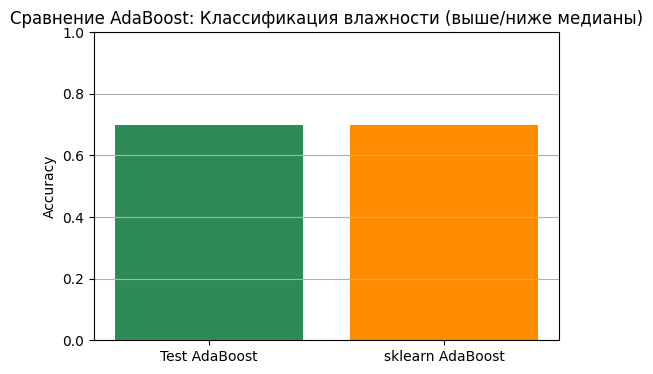

(0.6983333333333334, 0.6983333333333334)

In [16]:
weather_df = pd.read_csv("weather.csv")

humidity = weather_df["Humidity"].values
threshold = np.median(humidity)
y = np.where(humidity > threshold, 1, -1)  # метки: -1 / +1
X = weather_df[["Temperature", "Pressure"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model_simple = TestAdaBoost(n_estimators=50).fit(X_train, y_train)
y_pred_simple = model_simple.predict(X_test)
acc_simple = accuracy_score(y_test, y_pred_simple)

model_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50)
model_sklearn.fit(X_train, (y_train + 1) // 2)
y_pred_sklearn = model_sklearn.predict(X_test)
acc_sklearn = accuracy_score((y_test + 1) // 2, y_pred_sklearn)

plt.figure(figsize=(6, 4))
plt.bar(["Test AdaBoost", "sklearn AdaBoost"], [acc_simple, acc_sklearn], color=["seagreen", "darkorange"])
plt.ylabel("Accuracy")
plt.title("Сравнение AdaBoost: Классификация влажности (выше/ниже медианы)")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

acc_simple, acc_sklearn

## Radial basis kernel regression

**RBF-регрессия:**
$$
\hat{y}(x) = \sum_{i=1}^{n} \alpha_i \cdot \exp\left( -\gamma \|x - x_i\|^2 \right)
$$

**где веса находятся как:**
$$
\boldsymbol{\alpha} = (K + \lambda I)^{-1} \mathbf{y}
$$

**и ядро:**
$$
K(x, x') = \exp\left( -\gamma \|x - x'\|^2 \right)
$$


In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge


class TestRBFRegressor:
    def __init__(self, gamma=1.0, alpha=1e-6):
        """
        RBF-регрессия по формуле:
        \hat{y}(x) = \sum_{i=1}^{n} \alpha_i \cdot \exp(-\gamma \|x - x_i\|^2)
        Где alpha получается из решения (K + alpha*I)^{-1} y
        """
        self.gamma = gamma
        self.alpha_reg = alpha

    def _rbf_kernel(self, X1, X2):
        """ RBF-ядро: exp(-gamma * ||x - x'||^2) """
        dists = np.sum((X1[:, None, :] - X2[None, :, :]) ** 2, axis=2)
        return np.exp(-self.gamma * dists)

    def fit(self, X, y):
        """ Сохраняем обучающие данные и находим веса alpha """
        self.X_train = np.array(X).reshape(-1, X.shape[1])
        self.y_train = np.array(y).flatten()
        K = self._rbf_kernel(self.X_train, self.X_train)
        self.alpha = np.linalg.solve(K + self.alpha_reg * np.eye(K.shape[0]), self.y_train)
        return self

    def predict(self, X):
        """ Предсказание через ядро между X и обучающими X_train """
        X = np.array(X).reshape(-1, self.X_train.shape[1])
        K = self._rbf_kernel(X, self.X_train)
        return K @ self.alpha

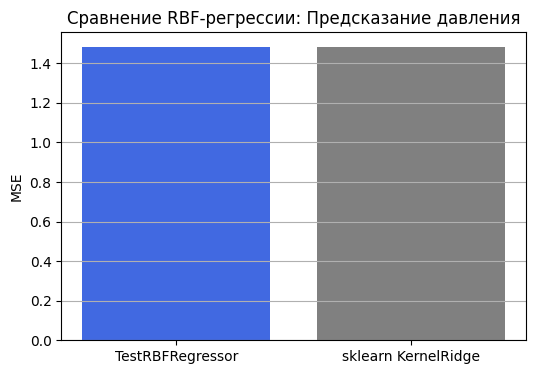

(1.4823938688360059, 1.4823964053718883)

In [18]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=1300, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=300, random_state=0)

model_rbf = TestRBFRegressor(gamma=0.01, alpha=1e-6).fit(X_train, y_train)
y_pred_rbf = model_rbf.predict(X_test)
mse_rbf = mean_squared_error(y_test, y_pred_rbf)

model_sklearn = KernelRidge(kernel="rbf", gamma=0.01, alpha=1e-6)
model_sklearn.fit(X_train, y_train)
y_pred_sklearn = model_sklearn.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

plt.figure(figsize=(6, 4))
plt.bar(["TestRBFRegressor", "sklearn KernelRidge"], [mse_rbf, mse_sklearn], color=["royalblue", "gray"])
plt.ylabel("MSE")
plt.title("Сравнение RBF-регрессии: Предсказание давления")
plt.grid(True, axis="y")
plt.show()

mse_rbf, mse_sklearn